## First Steps with GeoPandas

We'll always want these imports...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd

import pandas as pd

The simplest possible demonstration of GeoPandas plotting.  Just two parts:
* Import with `gpd.read_file()`...
* and `df.plot()`!

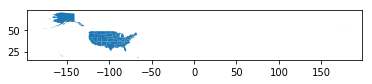

In [2]:
geo_df = gpd.read_file("data/cb_2015_us_state_20m.shp")
geo_df.plot()

Set the the STATEFP as an integer, as the index.  Have a look at the dataframe.

In [80]:
geo_df.set_index(geo_df["STATEFP"].astype(int), inplace = True)

Create a mask to toss out Alaska, Hawaii, and the territories...

In [4]:
contiguous =  (geo_df.index < 57)
contiguous &= (geo_df.index != 15)
contiguous &= (geo_df.index != 2)
geo_df = geo_df[contiguous]

Now experiment with projections:
* 4269 Plate carrée
* 3857 Web Mercator
* 2163 Albers Equal Area for the US.

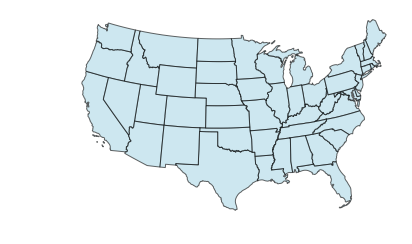

In [5]:
geo_df.to_crs(epsg = 2163).plot(facecolor = "lightblue", alpha = 0.6, edgecolor = "black").set_axis_off()

But even 2163 may not be appropriate for states.
* All states have their own (very-accurate) local projections.
* For Virginia use 3687, for Pennsylvania, 3364, for Illinois 3528...
* See [spatialreference.org](http://spatialreference.org/ref/epsg/3687/) for a complete list.

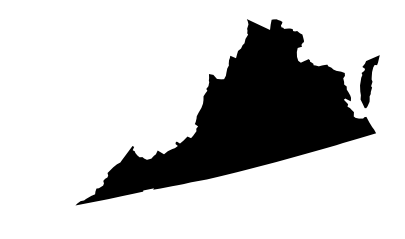

In [86]:
geo_df[geo_df.index == 51].to_crs(epsg = 2163).geometry.plot(color = "black").set_axis_off()

## Single Mothers by State

Download and format the state-by-state data; format the dataframe.  Set the State ID as the index as an integer, and rename the data column and cast it as a float.

In [7]:
import requests, pandas as pd
j = requests.get("http://api.census.gov/data/2015/acs5/profile?for=state:*&get=DP02_0037PE").json()
smom_df = pd.DataFrame(j[1:], columns = j[0])

smom_df["state"] = smom_df["state"].astype(int)
smom_df.set_index("state", inplace = True)

smom_df["DP02_0037PE"] = smom_df["DP02_0037PE"].astype(float)
smom_df.rename(columns = {"DP02_0037PE" : "Percent Mothers Unmarried"}, inplace = True)

smom_df.head()

,Percent Mothers Unmarried
state,
1,41.5
2,34.4
4,38.7
5,38.0
6,33.2


In [8]:
geo_merge = geo_df.join(smom_df, how = "inner")

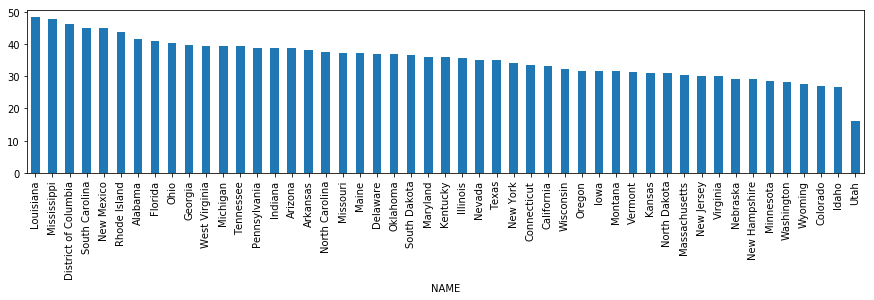

In [9]:
geo_merge.set_index("NAME")["Percent Mothers Unmarried"]\
         .sort_values(ascending = False)\
         .plot(kind = "bar", figsize = (15, 3))

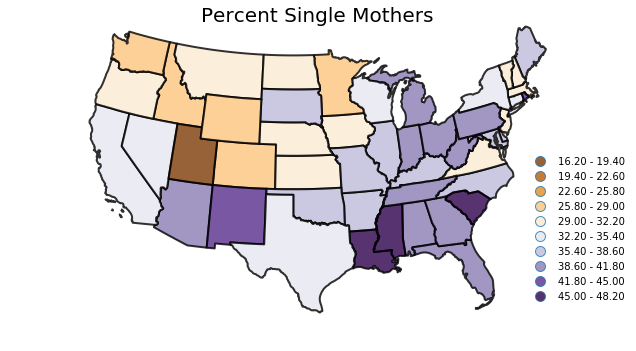

In [10]:
ft = "Percent Mothers Unmarried"

albers = geo_merge.to_crs(epsg=2163)
ax = albers.plot(column = ft, cmap = "PuOr", scheme = "equal_interval", k = 10, legend = True,
                 alpha = 0.8, linewidth = 2, edgecolor = "black", figsize = (9, 9))

ax.set_title("Percent Single Mothers", fontsize = 20, y = 0.95)
ax.set_axis_off()

ax.get_legend().set_bbox_to_anchor((1.13, 0.57))
ax.get_legend().get_frame().set_linewidth(0)

## Pennsylvania Election Returns

* Import pandas and geopandas, and the democratic vote shares from the last election.
* We first need to get this from the [PA state election site](http://www.electionreturns.pa.gov/).  After navigating to the right election and watching the network a bit, we get a [response](http://www.electionreturns.pa.gov/api/ElectionReturn/GetCountyBreak?officeId=1&districtId=1&methodName=GetCountyBreak&electionid=54&electiontype=G&isactive=0) that is _almost_ json.  The only complication is that it has extra escape characters that we have to remove. 

In [11]:
import requests, json
resp = requests.get("http://www.electionreturns.pa.gov/api/ElectionReturn/GetCountyBreak?"
                    "officeId=1&districtId=1&methodName=GetCountyBreak&electionid=54&electiontype=G&isactive=0")
j = json.loads(resp.text.replace("\\\"", "\"")[1:-1])

with open("data/pa_demshare.csv", "w") as out:
    out.write("county,demfrac2\n")
    for name, candidates in j["Election"]["Statewide"][0].items():
        demvotes = sum(int(c["Votes"]) for c in candidates if c["PartyName"] == "DEM")
        repvotes = sum(int(c["Votes"]) for c in candidates if c["PartyName"] == "REP")
        dem2frac = demvotes / (demvotes + repvotes)

        out.write("{},{:.4f} \n".format(name.lower(), dem2frac))

In [92]:
import pandas as pd, geopandas as gpd

demvote_df = pd.read_csv("data/pa_demshare.csv", index_col = "county").sort_index()
demvote_df.head()

,demfrac2
county,
adams,0.3115
allegheny,0.5862
armstrong,0.2341
beaver,0.4031
bedford,0.1571


In [93]:
counties = gpd.read_file("data/cb_2015_us_county_20m.shp")
counties["lname"] = counties["NAME"].str.lower()
counties = counties[counties["STATEFP"] == "42"].set_index("lname")

In [94]:
merged = counties.join(demvote_df, how = "inner")

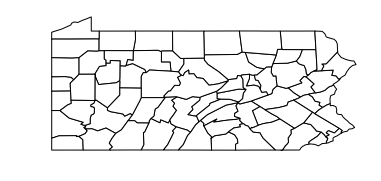

In [96]:
ax = counties.plot(edgecolor = "black", facecolor = "white")
ax.set_axis_off()

* Let's again make a Choropleth map, this time with `equal_interval`.
* This time, an appropriate CRS is 3364, for southern Pennsylvania ([spatial reference](http://spatialreference.org/ref/epsg/3364/)).

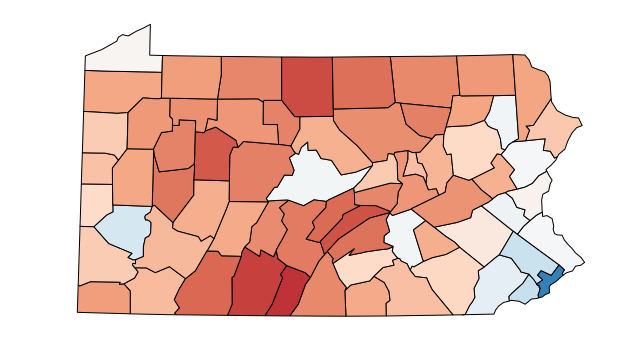

In [125]:
ax = merged.to_crs(epsg = 3364).plot(vmin = 0, vmax = 1, column = "demfrac2", cmap = "RdBu",
                                     edgecolor = "black", figsize = (10, 10))
ax.set_axis_off()


Here, as above, we download data frome the census.  This time, it's the percent of adults with a bachelor's degree, at the county level.

### Spatial and Non-Spatial Stories

Super common story after the election: Trump support very strong in regions with lower educational attainment.  Is that accurate?

In [132]:
import requests, pandas as pd
j = requests.get("http://api.census.gov/data/2015/acs5/profile?for=county:*&in=state:42&get=NAME,DP02_0067PE").json()
educ_df = pd.DataFrame(j[1:], columns = j[0])
educ_df["county"] = educ_df["NAME"].str.lower()
educ_df["county"] = educ_df["county"].str.replace(" county, pennsylvania", "")
educ_df.set_index("county", inplace = True)
educ_df["DP02_0067PE"] = educ_df["DP02_0067PE"].astype(float)
educ_df.rename(columns = {"DP02_0067PE" : "Bachelor's Degree"}, inplace = True)
educ_df.head()

,NAME,Bachelor's Degree,state
county,,,
adams,"Adams County, Pennsylvania",21.7,42
allegheny,"Allegheny County, Pennsylvania",37.8,42
armstrong,"Armstrong County, Pennsylvania",15.0,42
beaver,"Beaver County, Pennsylvania",22.8,42
bedford,"Bedford County, Pennsylvania",13.5,42


### Merge and Plot Bachelor's v. Share
Note again, the merging key is fundamentally geographical, though we're doing it with attributes.

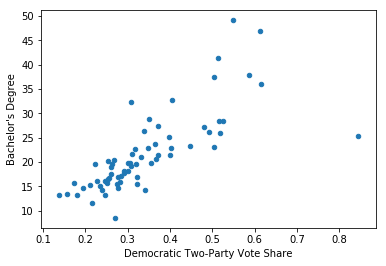

In [133]:
merged = demvote_df.join(educ_df, how = "inner")
ax = merged.plot(kind = "scatter", x = "demfrac2", y = "Bachelor's Degree")

ax.set_xlabel("Democratic Two-Party Vote Share")

# Spatial Joins

### Census Tracts
Import the tracts for chicago

In [149]:
tract_df = gpd.read_file("data/cb_2014_17_tract_500k.shp")
tract_df = tract_df[tract_df["COUNTYFP"] == "031"]
tract_df.rename(columns = {"NAME" : "Census Tract"}, inplace = True)

* Take a look at `first_degree_murders.csv`.
* There is no "geometry" column, but there _are_ latitudes and longitudes.
* Import it, and make the geometry.

In [150]:
crime_df = pd.read_csv("data/first_degree_murders.csv", usecols = [19, 20])
crime_df.dropna(inplace = True)


To make the geometry, do a list comprehension to create a point from every (longitude, latitude) pair.

In [151]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(crime_df.Longitude, crime_df.Latitude)]
crime_coords = gpd.GeoDataFrame(crime_df, crs = {'init': 'epsg:4269'}, geometry=geometry)

Have a look!!

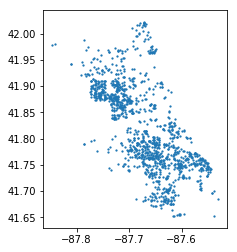

In [156]:
located_crimes.plot(markersize = 1.5)

Now, finally -- do that spatial join of murders to Community Areas!

In [153]:
located_crimes = gpd.sjoin(crime_coords, tract_df, how = 'left', op = 'within')

Aggregate these (groupby) to get a count per Census Tract:

In [ ]:
murder_tract_count = located_crimes.groupby("Census Tract").count()

Any column is the murder count, so just grab one:

In [157]:
murder_tract_count = murder_tract_count[["index_right"]].rename(columns = {"index_right" : "Murders"})

This is not a GeoDataFrame anymore!  Merge it back on, taking care to put the GeoDataFrame on the left.

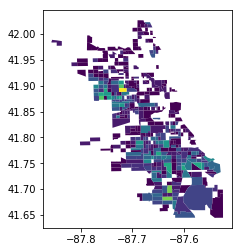

In [158]:
mapped_murders = pd.merge(tract_df, murder_tract_count, how = "inner", left_on = "Census Tract", right_index = True)
mapped_murders.plot(column = "Murders", k = 9, linewidth = 0)

### Again with Community Areas

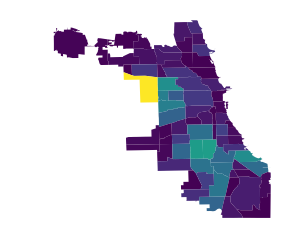

In [162]:
commu_df = gpd.read_file("data/community_areas.geojson")

crime_coords = gpd.GeoDataFrame(crime_df, crs = commu_df.crs, geometry=geometry)
located_crimes = gpd.tools.sjoin(crime_coords, commu_df, how = 'left', op = 'within')

located_crimes.rename(columns = {"index_right" : "Murders"}, inplace = True)
murder_area_count = located_crimes.groupby("community").count()[["Murders"]]

mapped_murders = pd.merge(commu_df, murder_area_count, how = "inner", left_on = "community", right_index = True)
ax = mapped_murders.plot(column = "Murders", k = 9, linewidth = 0)

ax.set_axis_off()

## Interactive Web Maps!?  AWESOME!!!

In this case, there's not much "reason" to it -- just follow the recipe.

In [173]:
import folium

m = folium.Map([40, -98], 
               tiles='cartodbpositron', 
               zoom_start=4, max_zoom=14, min_zoom=4)

ft = "Percent Mothers Unmarried"
colormap = folium.LinearColormap(("orange", "white", "purple"), 
                                 vmin = geo_merge[ft].min(), 
                                 vmax = geo_merge[ft].max(),
                                 caption = ft)

colormap.add_to(m)

folium.GeoJson(geo_merge,
               style_function = lambda feature: { 
                  'fillColor': colormap(feature['properties'][ft]),
                  "color" : "black", "weight" : 1, "fillOpacity" : 0.4
               }).add_to(m)

m.save("mothers.html")

m

## Spatial Associations and Geocoding

The various built-in geocoders are easier than handling the APIs directly:

In [177]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.geocode("1155. E 60th Street, Chicago")
location

Location(Harris School of Public Policy, 1155, East 60th Street, Woodlawn, Chicago, Cook County, Illinois, 60637, United States of America, (41.78544505, -87.5969593025297, 0.0))

In [240]:
from shapely.geometry import Point
pt = Point(-87.5940494865461, 41.7851555)

The gpd.tools gives us an easy means to construct a DataFrame:

In [255]:
places = gpd.tools.geocode(["London", "Paris", "Chicago", "Philadelphia", "New York"], "nominatim").to_crs(countries.crs)
places.head()

,address,geometry
0,"London, Greater London, England, UK",POINT (-0.1276474 51.5073219)
1,"Paris, Île-de-France, France métropolitaine, F...",POINT (2.3514992 48.8566101)
2,"Chicago, Cook County, Illinois, United States ...",POINT (-87.6244212 41.8755546)
3,"Philadelphia, Philadelphia County, Pennsylvani...",POINT (-75.16358990000001 39.9523993)
4,"NYC, New York, United States of America",POINT (-73.9866136 40.7306458)


Import a country map, and do a spatial join to get a list:

In [256]:
countries = gpd.read_file("data/TM_WORLD_BORDERS_SIMPL-0.3.shp")
origins = list(gpd.sjoin(countries, places, op = "contains").FIPS.unique())

Use `countries.FIPS.isin(origins)` as a boolean indicator or whether or not that country is in the list of points.

In [257]:
countries["origins"] = countries.FIPS.isin(origins)

Now plot the countries and cities:

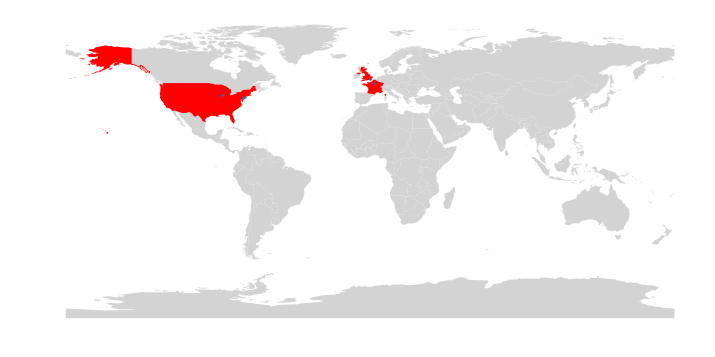

In [258]:
ax = countries.plot(color = "lightgrey", figsize = (12, 12))
countries[countries.origins].plot(ax = ax, color = "red")
places.plot(ax = ax, markersize = 2)
ax.set_axis_off()